<h1>Benchmarking code and results for the new implemented Virtual Destillation error mittigation method</h1>

In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
# general imports 
import sys
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
import cirq, cirq_google
import mitiq
import time

In [64]:
# importing our VD implementation

from vd import execute_with_vd, old_execute_with_vd

<h2>Start of benchmarking</h2>

<h3>1. One qubit circuits</h3>

<h4>1.1 depolarising noise on identity gates</h4>

In [4]:
# This function is used to calculate the expectation value of the Z operator on a one qubit circuit
def execute(circuit):
    """Returns Tr[ρ Z] where ρ is the state prepared by the circuit
    with depolarizing noise."""
    
    # density matrix
    dm = cirq.DensityMatrixSimulator().simulate(circuit).final_density_matrix 
    
    # print(dm)
    return dm[0, 0].real - dm[1, 1].real

In [6]:
# Identity circuit
rho = cirq.Circuit()
qubits = cirq.LineQubit.range(1)
rho.append(cirq.I(qubits[0])) # apply identity

noise_level = 0.1
noisy_rho = rho.copy().with_noise(cirq.depolarize(p=noise_level))

true_value = execute(rho) # Fault tolerant quantum computer
noisy_value = execute(noisy_rho) # Noisy quantum computer
vd_value = execute_with_vd(noisy_rho, 2, 1000)[0] # Noisy quantum computer + virtual distillation

print(f"True value: {true_value}")
print(f"Noisy value: {noisy_value}")
print(f"Virtual distillation value: {vd_value}")
print(f"Error w/o  virtual distillation: {abs((true_value - noisy_value) / true_value):.3f}")
print(f"Error w virtual distillation:    {abs((true_value - vd_value) / true_value):.3f}")

True value: 1.0
Noisy value: 0.8666667342185974
Virtual distillation value: 1.0011441647597255
Error w/o  virtual distillation: 0.133
Error w virtual distillation:    0.001


<h4>1.2 depolarising noise on randomised identity circuits</h4>

In [5]:
def random_circuit(n_qubits: int, num_cliffords: int) -> list:
    return mitiq.benchmarks.randomized_benchmarking.generate_rb_circuits(n_qubits=n_qubits, num_cliffords=num_cliffords, trials=1, return_type=None, seed=None)


In [ ]:
# returns a random benchmarking qubit circuit equal to identity

for i in range(10):
    rho = random_circuit(1, 10)[0]
    
    noise_level = 0.01 * i * 5
    noisy_rho = rho.copy().with_noise(cirq.depolarize(p=noise_level))

    true_value = execute(rho) # Fault tolerant quantum computer
    noisy_value = execute(noisy_rho) # Noisy quantum computer
    vd_value = execute_with_vd(noisy_rho, 2, 1000)[0] # Noisy quantum computer + virtual distillation

    print(f"circuit: {i}, noise level: {noise_level}")
    print(f"True value: {true_value}")
    print(f"Noisy value: {noisy_value}")
    print(f"Virtual distillation value: {vd_value}")
    print()


circuit: 0, noise level: 0.0
True value: 1.0
Noisy value: 1.0
Virtual distillation value: 1.0



KeyboardInterrupt: 

<h3>2. Multi qubit circuits</h3>

<h4>2.1 depolarising noise on randomised two qubit identity circuits</h4>

In [8]:
# 2 qubit benchmarking circuits
for i in range(10):
    rho = random_circuit(2, 10)[0]
    
    noise_level = 0.01 * i
    noisy_rho = rho.copy().with_noise(cirq.depolarize(p=noise_level))

    true_value = execute(rho) # Fault tolerant quantum computer
    noisy_value = execute(noisy_rho) # Noisy quantum computer
    vd_value = execute_with_vd(noisy_rho, 2, 1000)[0] # Noisy quantum computer + virtual distillation

    print(f"circuit: {i}, noise level: {noise_level}")
    print(f"True value: {true_value}")
    print(f"Noisy value: {noisy_value}")
    print(f"Virtual distillation value: {vd_value}")
    print()

circuit: 0, noise level: 0.0
True value: 1.0
Noisy value: 1.0
Virtual distillation value: 1.0

circuit: 1, noise level: 0.01
True value: 1.0
Noisy value: 0.2768705189228058
Virtual distillation value: 0.38235294117647056

circuit: 2, noise level: 0.02
True value: 1.0
Noisy value: 0.03222043812274933
Virtual distillation value: 0.04594594594594595

circuit: 3, noise level: 0.03
True value: 1.0
Noisy value: 0.014376461505889893
Virtual distillation value: 0.054187192118226604

circuit: 4, noise level: 0.04
True value: 1.0
Noisy value: 0.003016531467437744
Virtual distillation value: 0.12771739130434784

circuit: 5, noise level: 0.05
True value: 1.0
Noisy value: 0.0006730556488037109
Virtual distillation value: 0.06868131868131869

circuit: 6, noise level: 0.06
True value: 1.0
Noisy value: 0.0001665353775024414
Virtual distillation value: 0.07673267326732673

circuit: 7, noise level: 0.07
True value: 1.0
Noisy value: 4.5865774154663086e-05
Virtual distillation value: 0.06976744186046512



In [54]:
import matplotlib.pyplot as plt

def present_in_plot(measurement_list, reference_value, observable_name:str ="Z", Y_vals_info=[], rel_err_on_Y=True , title="n qubits randomised identity circuit benchmark"):
    

    X, *Ys = list(zip(*measurement_list))
    xmin, xmax = 0.91 * np.min(X), 1.1 * np.max(X)

    assert len(Ys) == len(Y_vals_info), "mismath Ys and Y-infos"

    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)
    hline_label = "random guesing error" if rel_err_on_Y else "true value"
    ax.axhline(reference_value, xmin, xmax, color='blue', lw="1", ls="-.", label=hline_label)

    for i, Y in enumerate(Ys):
        ax.plot(X, Y, label=Y_vals_info[i], lw=1, ms=4, marker='^')




    ax.set_xlabel("Expected # of errors")
    ax.set_xscale('log')
    if rel_err_on_Y:
        ax.set_yscale('log')
        ax.set_ylabel(f"square root distance of $\\langle {observable_name}_i \\rangle $ vector to true state")
    else:
        ax.set_ylabel(f"$\\langle {observable_name}_1 \\rangle $ of the first qubit")
        ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(xmin, xmax)
    ax.legend()
    ax.set_title(title)

    return fig


C:\Users\jari\AppData\Local\Temp\ipykernel_30064\269706115.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  test_fig.show()


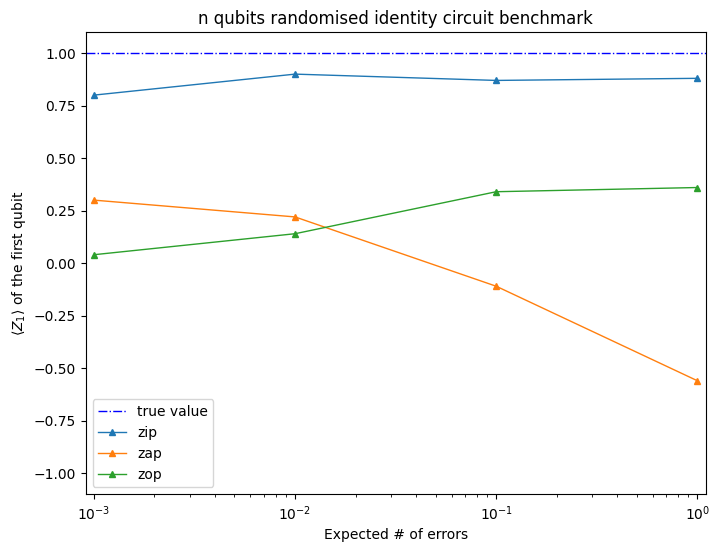

In [48]:
test_fig = present_in_plot([(0.001, 0.8,0.3,0.04),(0.01,0.9,0.22,0.14),(0.1,0.87,-0.11,0.34),(1,0.88,-0.56,0.36)], 1, "Z", ["zip", "zap", "zop"])
a = 1
test_fig.show()

In [7]:
# Generally usable progress bar :DDD

class progressBar():
    def __init__(self, maxTicks:int, size=40):
        self.maxTicks = maxTicks
        self.currentTicks = 0
        self.T0 = time.time()
        self.T1 = 0.0
        self.size = size
        progress_float = 0.0
        progress_str = " " * self.size
        print(f"Running: |{progress_str}|{progress_float:6.1%}", end='\r')

    def addTicks(self, NTicks):
        self.currentTicks += NTicks
        progress_float = self.currentTicks/self.maxTicks
        progress_str = "#" * round(self.size * progress_float) + " " * (self.size - round(self.size * progress_float))
        self.T1 = time.time()
        est_time = int((1-progress_float)/progress_float * (self.T1-self.T0))
        elapsed_time = int(self.T1-self.T0)
        print(f"Running: |{progress_str}|{progress_float:6.1%} \t T ~ { est_time//60:3d}m {est_time%60:2d}s left \t (tot: {(elapsed_time+est_time)//60:3d}m {(elapsed_time+est_time)%60:2d}s){' ':100}", end='\r')

    def finished(self):
        self.currentTicks = self.maxTicks
        progress_float = 1.0
        self.T1 = time.time()
        elapsed_time = int(self.T1-self.T0)
        print(f"Finished:|{'-'*((self.size-4)//2)}DONE{'-'*((self.size-3)//2)}|{progress_float:6.1%} \t T elapsed: { elapsed_time//60:3d}m {elapsed_time%60:2d}s {' ':100}")

In [25]:
# 1 qubit benchmarking circuits
BMrun_test_1q = []

pBar = progressBar(30 * (2 + 50 + 100 + 1000))

for i, N_exp_Err in enumerate(np.logspace(-2, 0, base=10, num=30)):
    N_gates = 50
    
    rho = random_circuit(1, N_gates)[0]
    
    noise_level = N_exp_Err / N_gates
    noisy_rho = rho.copy().with_noise(cirq.depolarize(p=noise_level))


    true_value_m = execute(rho) # Fault tolerant quantum computer
    pBar.addTicks(1)
    noisy_value_m = execute(noisy_rho) # Noisy quantum computer
    pBar.addTicks(1)
    m_list = [N_exp_Err, true_value_m, noisy_value_m]
    BMrun_test_1q_info = ["Fault tolerant", "Noisy"]
    for K in [50, 100, 1000]:
        vd_value_m = execute_with_vd(noisy_rho, 2, K)[0] # Noisy quantum computer + virtual distillation
        m_list.append(vd_value_m)
        BMrun_test_1q_info.append(f"vd: {K=}")
        pBar.addTicks(K)

    BMrun_test_1q.append( tuple(m_list) )
    

pBar.finished()




Running: |------------------DONE------------------|100.0% 	 T elapsed:  59m 48s                                                                                                                   


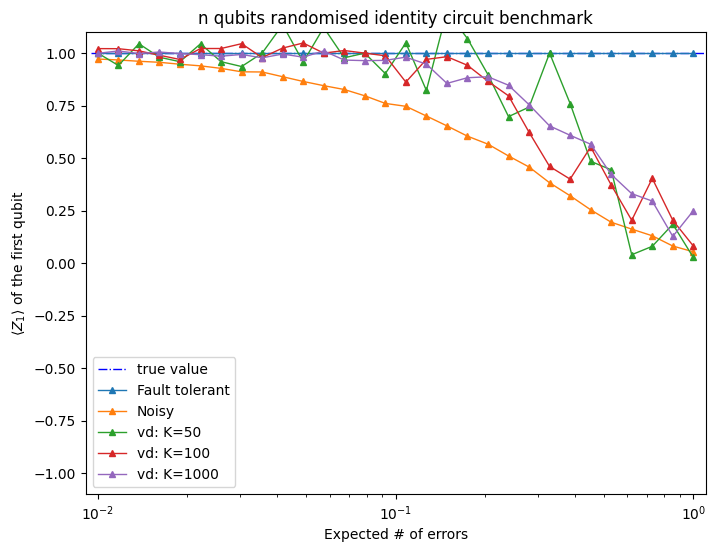

In [26]:

BMrun_test_fig = present_in_plot(BMrun_test_1q, 1, 'Z', BMrun_test_1q_info)

In [9]:
# 2 qubit benchmarking circuits
BMrun_test = []

pBar = progressBar(20 * (3 + 10 + 50))

for i, N_exp_Err in enumerate(np.logspace(-2, 0, base=2, num=20)):
    N_gates = 10
    
    rho = random_circuit(2, N_gates)[0]
    
    noise_level = N_exp_Err / N_gates
    noisy_rho = rho.copy().with_noise(cirq.depolarize(p=noise_level))


    true_value_m = execute(rho) # Fault tolerant quantum computer
    pBar.addTicks(1)
    noisy_value_m = execute(noisy_rho) # Noisy quantum computer
    pBar.addTicks(1)
    m_list = [N_exp_Err, true_value_m, noisy_value_m]
    m_info = ["Fault tolerant", "Noisy"]
    for K in [1, 10, 50]:
        vd_value_m = execute_with_vd(noisy_rho, 2, K)[0] # Noisy quantum computer + virtual distillation
        m_list.append(vd_value_m)
        m_info.append(f"vd: {K=}")
        pBar.addTicks(K)

    BMrun_test.append( tuple(m_list) )
    

pBar.finished()




TypeError: unsupported operand type(s) for //: 'str' and 'int'

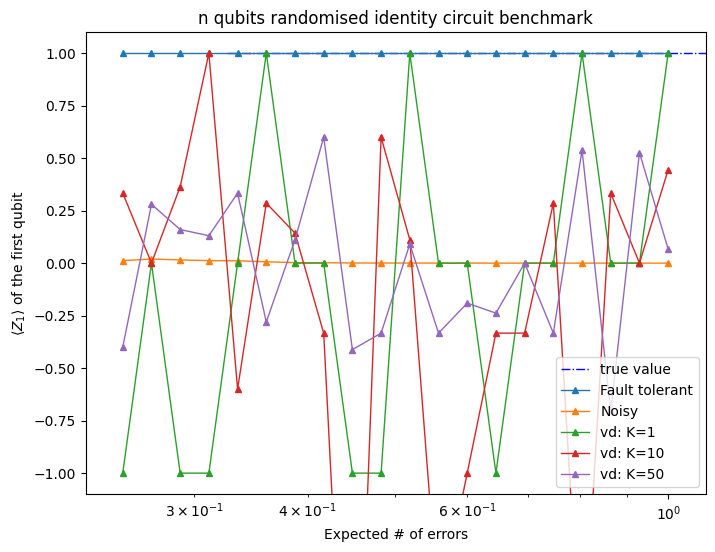

In [10]:
BMrun_test_fig = present_in_plot(BMrun_test, 1, 'Z', m_info)


<h3>Creating non-identity randomised benchmarking cirquits on n qubits</h3>
These are an attempt to replicate the benchmarking circuits used in the VD paper, based on the circuits from this google paper: https://www.nature.com/articles/|s41586-019-1666-5

In [20]:
def create_randomised_benchmarking_circuit(N_qubits, depth ,entanglement=True, seed=None):
    single_qubit_gates = np.array([cirq.XPowGate, cirq.YPowGate, cirq.ZPowGate])

    qubits = [cirq.LineQubit(i) for i in range(N_qubits)]
    
    if seed == None:
        RNG = np.random.default_rng()
    else:
        RNG = np.random.default_rng(seed)
    
    operations = []
    entanglement_gate_count = 0
    entanglement_offset = 0

    for l in range(depth + 1):
        layer_gate_numbers = RNG.choice(3, N_qubits) # N_qubit numbers of 0 to 2, identifying one of the s.q. gates from the list for each qubit
        layer_gate_exponents = RNG.choice([0.5, 1.0], N_qubits) # determine the exponent for each gate, so we apply eithet X or X^1/2, resp. for Y and Z
        for i in range(N_qubits):
            gate = single_qubit_gates[layer_gate_numbers[i]]
            operations.append(gate(exponent=layer_gate_exponents[i]).on(qubits[i], ))

        # add syncamore gates, alternating between left and right neighbours
        if entanglement and l < depth:
            for i in range(entanglement_offset, N_qubits, 2):
                if i+1 < len(qubits): 
                    operations.append(cirq_google.ops.SycamoreGate().on(qubits[i], qubits[i+1]))
            entanglement_offset = 1 - entanglement_offset # alternate between 0 and 1


    pure_rand_qc = cirq.Circuit(operations)


    return pure_rand_qc, len(operations), entanglement_gate_count

In [27]:
test_circ_1, *args = create_randomised_benchmarking_circuit(6, 4, 0.1, True)
print(test_circ_1)

# test_circ_2,test_circ_2_noisy = create_randomised_benchmarking_circuit(3, 4, False, 123456)
# test_circ_3,test_circ_3_noisy = create_randomised_benchmarking_circuit(3, 4, False, 123456)
# test_circ_4,test_circ_4_noisy = create_randomised_benchmarking_circuit(3, 4, False, 123456)

# print('\n\n\n', test_circ_2,'\n\n', test_circ_3,'\n\n', test_circ_4)


0: ───Y───────SYC───X^0.5───S───────────────SYC───S───────Z─────────────
              │                             │
1: ───Y───────SYC───S───────SYC─────X^0.5───SYC───X^0.5───SYC───S───────
                            │                             │
2: ───S───────SYC───X───────SYC─────Y───────SYC───Y^0.5───SYC───X───────
              │                             │
3: ───S───────SYC───Y───────SYC─────S───────SYC───X^0.5───SYC───S───────
                            │                             │
4: ───X───────SYC───Y───────SYC─────X^0.5───SYC───X^0.5───SYC───X^0.5───
              │                             │
5: ───X^0.5───SYC───Y───────X^0.5───────────SYC───Z───────Y─────────────


In [23]:
def expectation_Zi(circuit):
    """Returns Tr[ρ Z] where ρ is the state prepared by the circuit
    with depolarizing noise."""
    
    # density matrix
    dm = cirq.DensityMatrixSimulator().simulate(circuit).final_density_matrix 
    
    n_qubits = cirq.num_qubits(circuit)
    Z = np.array([[1, 0], [0, -1]])

    Zi_operators = np.array([ np.kron(np.kron(np.eye(2**i), Z), np.eye(2**(n_qubits-i-1))) for i in range(n_qubits)])

    # print(Zi_operators)

    Zi = np.trace(Zi_operators@ dm, axis1=1, axis2=2)
    return Zi

In [28]:
test_circ_Z = expectation_Zi(test_circ_1)

test_circ_1_noisy = test_circ_1.copy().with_noise(cirq.depolarize(p=0.01))

test_circ_noisy_Z = expectation_Zi(test_circ_1_noisy)
print(test_circ_Z)
print(test_circ_noisy_Z)

[-2.42143869e-08-1.86264515e-09j  0.00000000e+00+0.00000000e+00j
 -6.69872705e-02+5.58793545e-09j -2.50000020e-01+1.86264515e-09j
 -3.12500011e-01+3.72529030e-09j  9.31322575e-10-5.58793545e-09j]
[ 4.61004674e-08+2.06753675e-09j -8.24030349e-03+7.35123784e-09j
 -5.93644609e-02-3.44589332e-09j -2.21550854e-01+6.43233437e-09j
 -2.71971483e-01+8.04042004e-10j -1.07567757e-07-5.51342867e-09j]


In [35]:
def vector_norm_distance(V, W):
    return np.linalg.norm((V - W))

In [36]:
print( vector_norm_distance(test_circ_Z, test_circ_noisy_Z))

0.05077328493796946


<h3>Benchmarking on n qubit non-identity circuits</h3>

In [ ]:
# 1 qubit benchmarking circuits
BMrun_1q_non_entangled = []


N_qubits = 1
N_layers = 20
rho, gate_count, entangle_gate_count = create_randomised_benchmarking_circuit(N_qubits, N_layers, entanglement=False)

# (re)create a random circuit until at least one expectation value is nonzero
true_Zi = expectation_Zi(rho) # Fault tolerant quantum computer
while np.all(true_Zi == 0.+0.j):
    print("nope")
    rho, gate_count, entangle_gate_count = create_randomised_benchmarking_circuit(N_qubits, N_layers, entanglement=False)
    true_Zi = expectation_Zi(rho) # Fault tolerant quantum computer

print(rho)
dist_true_Zi = 0.0

pBar = progressBar(1 + 10 * (1 + 50 + 100 + 10))
pBar.addTicks(1)

for i, N_exp_Err in enumerate(np.logspace(-2, 0, base=10, num=10)):

    noise_level = N_exp_Err / gate_count
    noisy_rho = rho.copy().with_noise(cirq.depolarize(p=noise_level))
    # print(noisy_rho)

    noisy_Zi = expectation_Zi(noisy_rho) # Noisy quantum computer
    dist_noisy_Zi = vector_norm_distance(true_Zi, noisy_Zi)

    # print(N_exp_Err, true_Zi, noisy_Zi)
    pBar.addTicks(1)

    measurement_list = [N_exp_Err, dist_noisy_Zi]
    BMrun_1q_non_entangled_info = ["Noisy"]

    for K in [10, 50, 100]:
        vd_Zi = execute_with_vd(noisy_rho, 2, K) # Noisy quantum computer + virtual distillation
        dist_vd_Zi = vector_norm_distance(true_Zi, vd_Zi)
        measurement_list.append(dist_vd_Zi)
        BMrun_1q_non_entangled_info.append(f"vd: {K=}")
        pBar.addTicks(K)

    BMrun_1q_non_entangled.append( tuple(measurement_list) )
    

pBar.finished()




nopeing: |                                        |  0.0%
nope
0: ───Z───Z───Y───S───Y^0.5───X^0.5───S───Y───S───X───Y^0.5───X───Y───X───X───Y───Y^0.5───Y^0.5───X───Z───
Running: |------------------DONE------------------|100.0% 	 T elapsed:   0m 31s                                                                                                                   


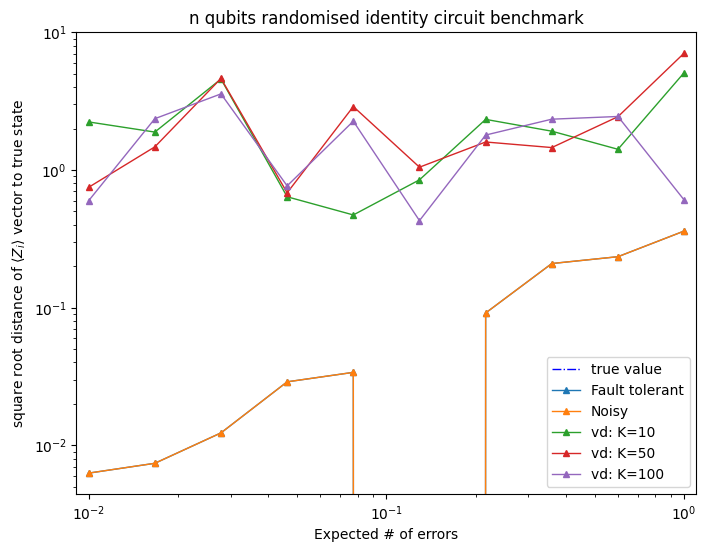

In [86]:
BMrun_3q_non_entangled_fig = present_in_plot(BMrun_3q_non_entangled, 0.0, 'Z', BMrun_3q_non_entangled_info)

c:\Users\jari\Documents\Studie\M_Jaar_1_2024-2025\Near_Term_QC\VENV_QisKit\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\jari\Documents\Studie\M_Jaar_1_2024-2025\Near_Term_QC\VENV_QisKit\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


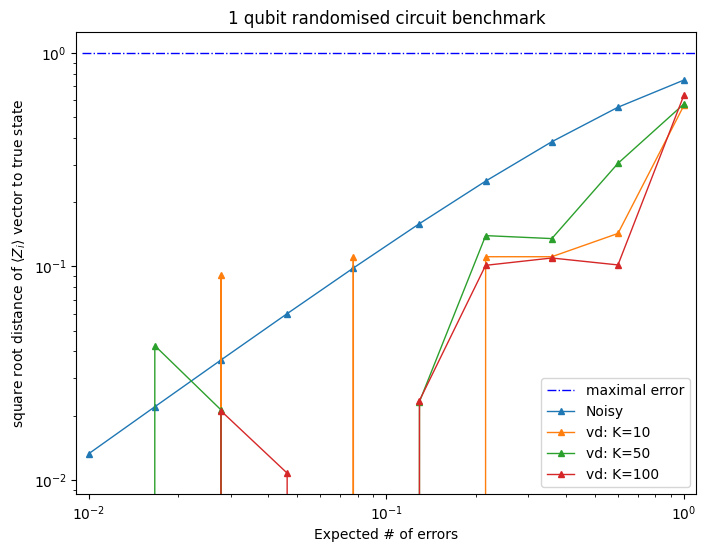

In [ ]:
dist_random_state = vector_norm_distance(true_Zi, np.zeros(N_qubits))

BMrun_1q_non_entangled_fig = present_in_plot(BMrun_1q_non_entangled, dist_random_state, 'Z', BMrun_1q_non_entangled_info, title="1 qubit randomised circuit benchmark")

In [47]:
# Running and saving a benchmarking iteration

import pickle

# Settings
N_qubits=6
N_layers=20

rho, gate_count, entangle_gate_count = create_randomised_benchmarking_circuit(N_qubits, N_layers, entanglement=True)
# (re)create a random circuit until at least one expectation value is nonzero
true_Zi = expectation_Zi(rho) # Fault tolerant quantum computer
while np.all(true_Zi == 0.+0.j):
    print("nope")
    rho, gate_count, entangle_gate_count = create_randomised_benchmarking_circuit(N_qubits, N_layers, entanglement=True)
    true_Zi = expectation_Zi(rho) # Fault tolerant quantum computer

print(rho)
dist_true_Zi = 0.0

BMrun = {
    "benchmark_name": "Benchmark 6q entangled random circuit",
    "observable": "Z",
    "N_qubits":N_qubits,
    "N_layers":N_layers,
    "rho":rho,
    "gate_count":gate_count,
    "entangle_gate_count":entangle_gate_count
}

assert input("Is the name correctly changed? [N/y] ") == 'y', "Aborted, please change the name."



pBar = progressBar(1 + 1 + 10 * (1 + 50 + 200 + 1000))
pBar.addTicks(1)

datapoints = []
datapoint_labels = []

for i, N_exp_Err in enumerate(np.logspace(-2, 0, base=10, num=10)):

    noise_level = N_exp_Err / gate_count
    noisy_rho = rho.copy().with_noise(cirq.depolarize(p=noise_level))
    # print(noisy_rho)

    noisy_Zi = expectation_Zi(noisy_rho) # Noisy quantum computer
    dist_noisy_Zi = vector_norm_distance(true_Zi, noisy_Zi)

    # print(N_exp_Err, true_Zi, noisy_Zi)
    pBar.addTicks(1)

    measurement_list = [N_exp_Err, dist_noisy_Zi]
    datapoint_labels = ["Noisy"]

    for K in [50, 200, 1000]:
        vd_Zi = execute_with_vd(noisy_rho, 2, K) # Noisy quantum computer + virtual distillation
        dist_vd_Zi = vector_norm_distance(true_Zi, vd_Zi)
        measurement_list.append(dist_vd_Zi)
        datapoint_labels.append(f"vd: {K=}")
        pBar.addTicks(K)

    datapoints.append( tuple(measurement_list) )
    
BMrun["true_Zi"] = true_Zi
BMrun["datapoints"] = datapoints
BMrun["datapoint_labels"] = datapoint_labels


with open( BMrun["benchmark_name"].replace(" ", "_") + '.pkl', 'wb') as f:
    pickle.dump(BMrun, f)

pBar.finished()




0: ───S───────SYC───Y^0.5───Z───────────SYC───Y───────S─────────────SYC───S───────Z─────────SYC───Z───────Y^0.5───────────SYC───Z───Z───────────────SYC───Y───────X^0.5───────────SYC───Y^0.5───Y───────────────SYC───X^0.5───Y───────────────SYC───Z───────S───────────────SYC───Y^0.5───X^0.5───────────
              │                         │                           │                       │                             │                         │                             │                             │                             │                             │
1: ───Z───────SYC───S───────SYC─────Y───SYC───Y^0.5───SYC───X^0.5───SYC───Y^0.5───SYC───Z───SYC───Y───────SYC─────Z───────SYC───S───SYC─────S───────SYC───Y───────SYC─────Y───────SYC───Z───────SYC─────S───────SYC───Y^0.5───SYC─────Y^0.5───SYC───Y^0.5───SYC─────Y^0.5───SYC───Z───────SYC─────S───────
                            │                         │                           │                       │                         

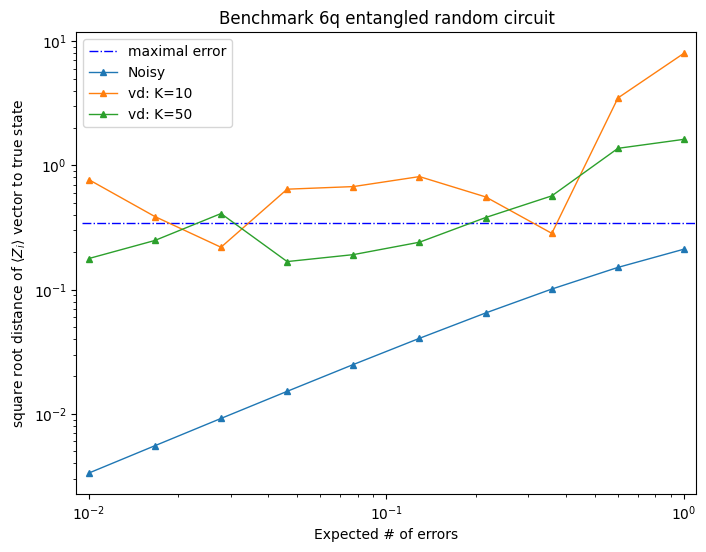

In [46]:
dist_random_state = vector_norm_distance(BMrun["true_Zi"], np.zeros(BMrun["N_qubits"]))

BMrun_fig = present_in_plot(BMrun["datapoints"], dist_random_state, BMrun["observable"], BMrun["datapoint_labels"], title=BMrun["benchmark_name"])

In [59]:
# list of benchmark names of interest

BM_runs = {
    "test":"Test_disjoint_BM_1q.pkl",
    "6q_entangled":"Benchmark_6q_entangled_random_circuit.pkl",
    "6q_non-entangled":"BM_6q_non_entangled.pkl"
}

In [49]:
def plot_BM_run(file_name):

    with open(file_name, 'rb') as f:
        BM_dict = pickle.load(f)
    
    dist_random_state = vector_norm_distance(BM_dict["true_Zi"], np.zeros(BM_dict["N_qubits"]))

    BM_fig = present_in_plot(BM_dict["datapoints"], dist_random_state, BM_dict["observable"], BM_dict["datapoint_labels"], title=BM_dict["benchmark_name"])  

    return BM_fig

C:\Users\jari\AppData\Local\Temp\ipykernel_3792\2679220533.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  testrun.show()


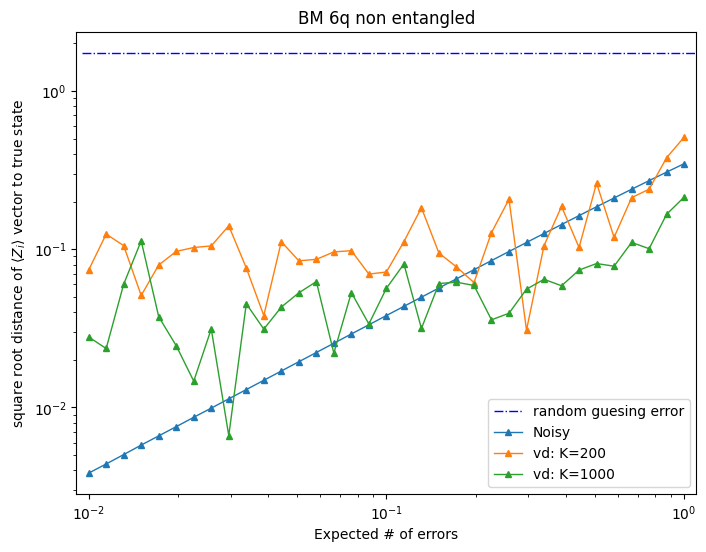

In [60]:
testrun = plot_BM_run(BM_runs['6q_non-entangled'])

testrun.show()

In [66]:
rho, *args = create_randomised_benchmarking_circuit(3, 30, True, 24756822562243)
noisy_rho = rho.copy().with_noise(cirq.depolarize(p=0.01))
T0 = time.time()
new = execute_with_vd(noisy_rho)
T1 = time.time()
old = old_execute_with_vd(noisy_rho)
T2 = time.time()

print(f"New: {T1-T0:10.4f} s")
print(f"Old: {T2-T1:10.4f} s\n\n")
print(new, old)

New:    17.1030 s
Old:    17.0429 s


[0.13725490196078433, 0.17647058823529413, -0.3333333333333333] [-0.2857142857142857, 0.0, -0.5714285714285714]
